In [1]:
import simos as sos
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### In this notebook, we will explore optically detected magnetic field effects (MFEs) in Spin-Correlated Radical Pairs. For a more basic introduction on SCRP spin dynamics please check out our introductory notebook in a symbolic framework. For an introduction to MFEs, consult our notebook on MFEs in simple model radical pair systems. 

Here we qualitatively reproduce recent work by Buck et al. The 2J resonance of a strongly coupled radical pair is detected via fluoresence lifetime and intensity. In contrast to our simulations of the MFE in the simple model system, this example critically requires the combined simulation of coherent and incoherent dynamics with a quantum master equation. 

For all details and explanations, please have a look at the original publication: J. Am. Chem. Soc. 2020, 142, 20691−20700. 

Again, we start by initialising the composite system that encompasses the SCRP and the associated electronic levels. 



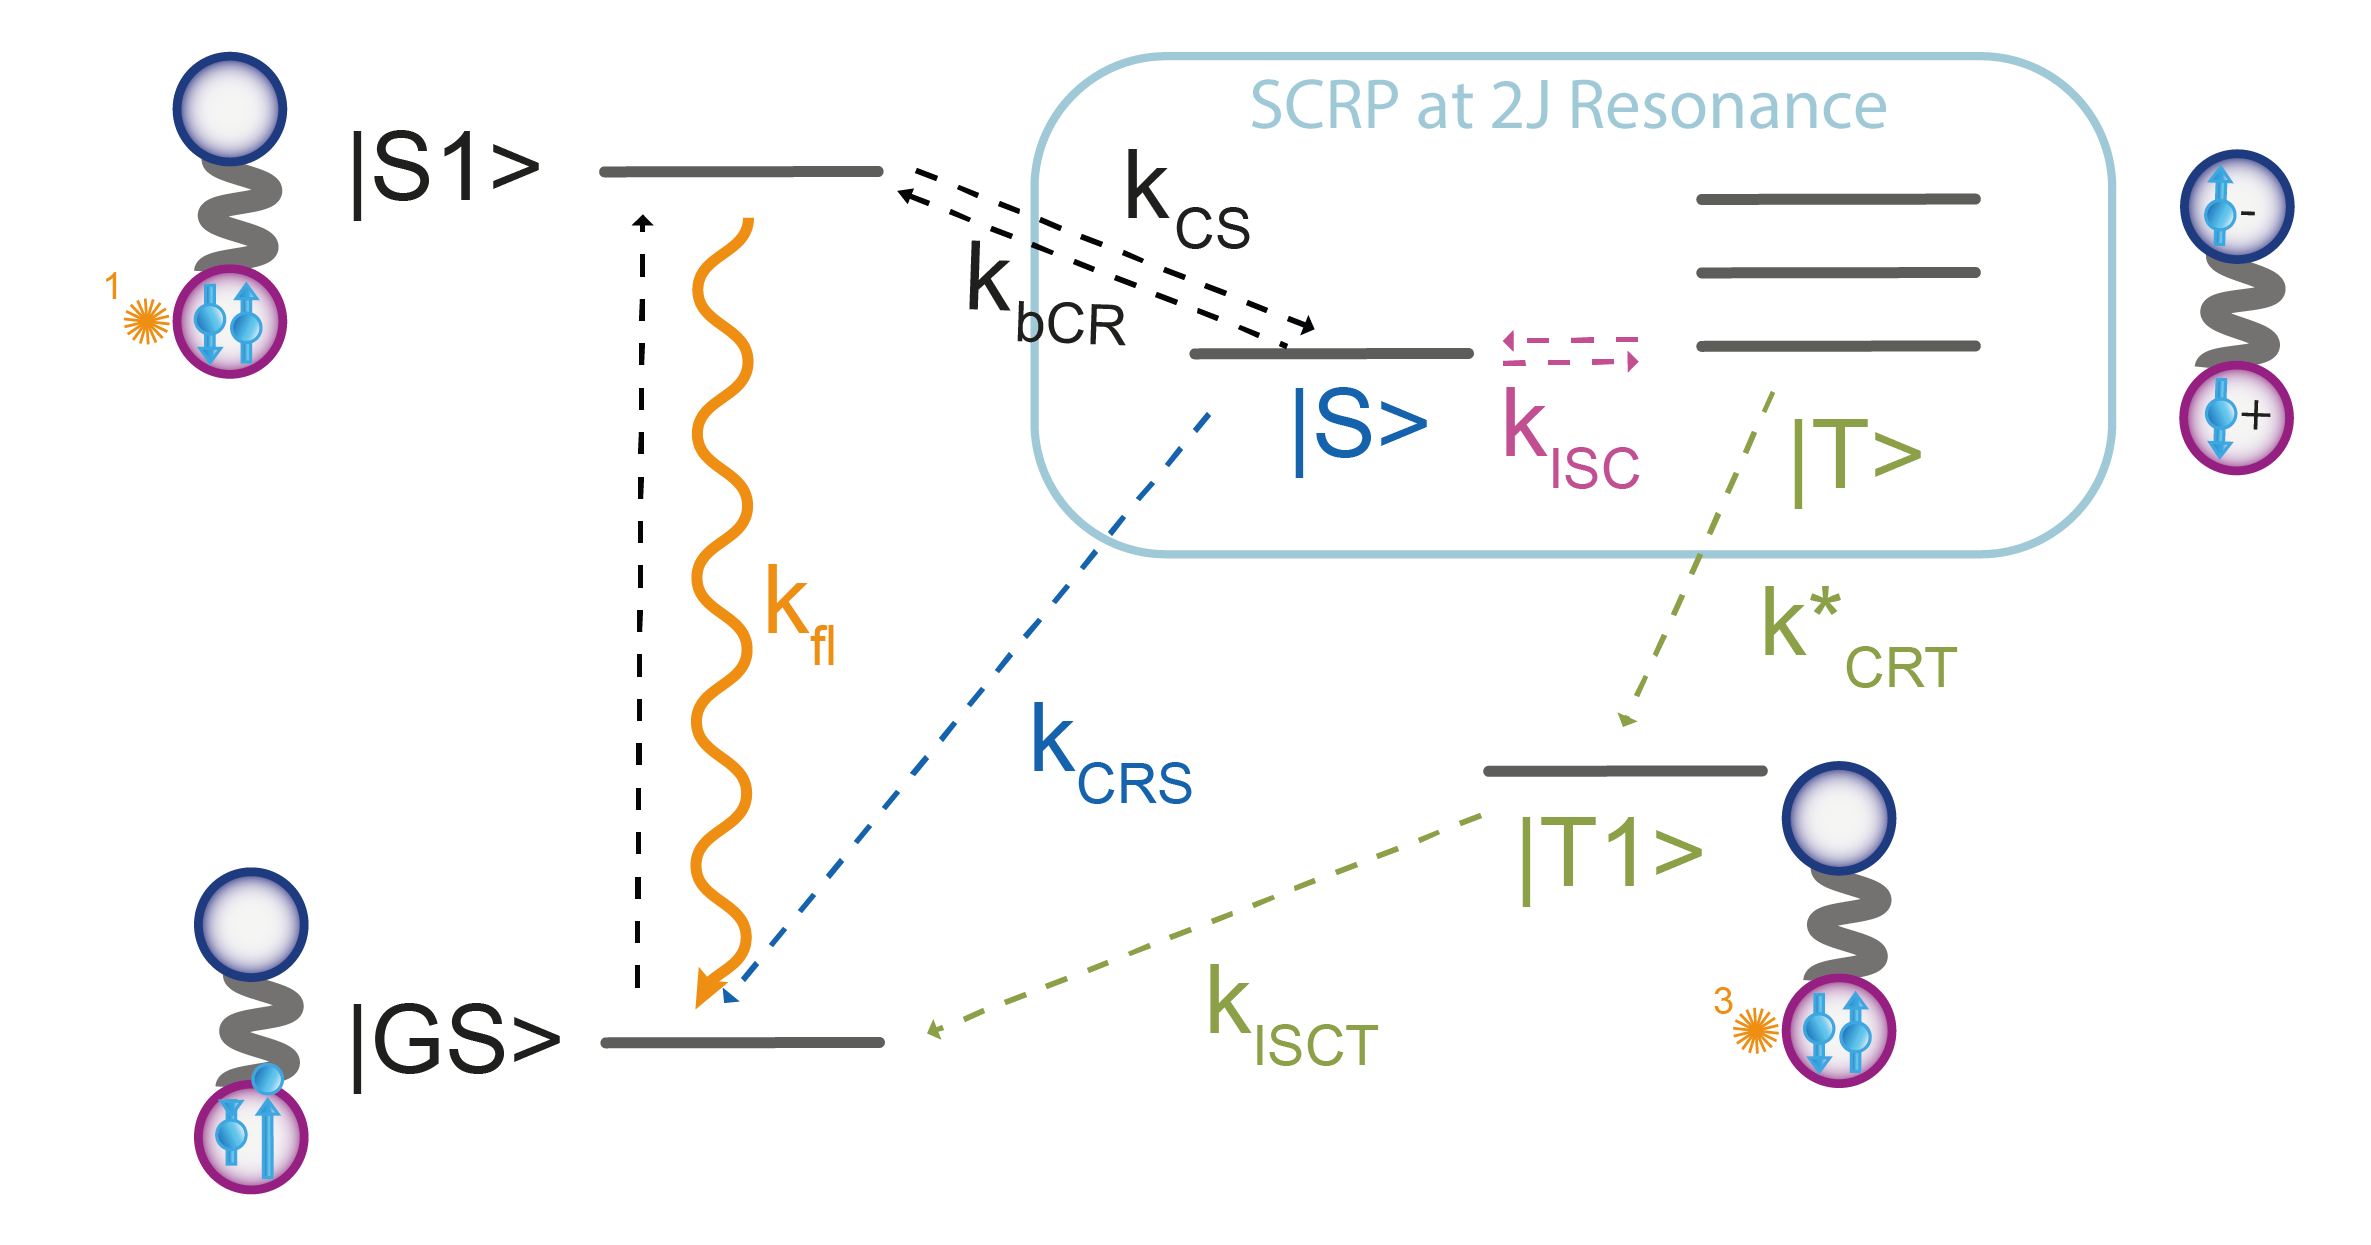

In [55]:
from IPython.display import Image
Image(filename='img/examples_tomomfe.png', width=500)

In addition, we include a nuclear spin to allow for hyperfine-mediated singlet-triplet-interconversion. 

In [13]:
# Initialise all system members.
A = {'val': 1/2, 'name':'A'} # first electron spin of the SCRP
B = {'val': 1/2 , 'name':'B'} # second electron spin of the SCRP
H = {'val': 1/2 , 'name':'H'} # nuclear spin, coupled to SCRP 
GS =  {'val': 0 , 'name':'GS'} 
S1 =  {'val': 0 , 'name':'S1'} 
T1 =  {'val': 0 , 'name':'T1'} 

# Construct the system. 
rp = sos.System((GS, S1, [A,B, H], T1), method = "qutip")
rp.add_ghostspin("C", ["A", "B"])

# Also prepare the singlet and triplet states.
S =  (rp.C_1p[0].unit())   # singlet case 
T0 =  (rp.C_3p[0].unit()) # triplet 0
Tp =   (rp.C_3p[1].unit()) # triplet 1
Tm =   (rp.C_3p[-1].unit()) # triplet 1

Define the coherent interactions (no rotating frame, since the experiment is performed in solution this is a purely isotropic case, dipolar coupling is not considered here.)

In [49]:
yH = sos.yH1 # gyromagnetic ratio proton 
yA = sos.ye # gyromagnetic ratio first electron
yB = sos.ye # gyromagnetic ratio second electron 
a = sos.f2w(1.5e7)  # hyperfine coupling 
J=  100e-3*sos.ye # J coupling 2J = 100 mT 

# Isotropic Hyperfine interaction between Spins A and H 
Hhfi = a*(rp.Ax*rp.Hx + rp.Ay*rp.Hy + rp.Az*rp.Hz)
# Isotropic J-Coupling between Spins A and B
HJ = J*(rp.Ax*rp.Bx + rp.Ay*rp.By + rp.Az*rp.Bz)
# The Zeeman Hamiltonian
HZ = lambda B: yH*B*rp.Hz + yA*B*rp.Az + yB*B*rp.Bz 

Define the incoherent interactions. Here, we utilize SimOS utility functions for generation of collapse operators. We set up a dictionary that holds the transitions and their rates.
We first tidy up the dictionary with the tidyup_ratedict function and then generate the collapse operators with the transition_operators function.  

In [50]:
# All rates are in 1/s
emission_rate = 0.51e9
beta  = 0.8

rates = {}
rates_laser = {}

# Excitation and fluorescent decay, GS, S1
rates_laser["GS->S1"]  = 0.2*emission_rate
rates["S1->GS"] = emission_rate

# Charge separation
rates["S1->C_1[0]"] = 2.82e8
rates["S1<-C_1[0]"] =  0.20e7

# Charge recombination 
rates["C_1[0] -> GS"] = 13.8e6
rates["C_3[-1]-> T1"] = 5.20e8
rates["C_3[0] -> T1"] = 5.20e8
rates["C_3[1] -> T1"] = 5.20e8

rates["T1 -> GS"] = 1e5

allrates = sos.fuse_dictionaries(rates_laser,rates)
c_ops_off = sos.transition_operators(rp, rates)
c_ops_on = sos.transition_operators(rp, allrates)


Here, we run the actual simulation. For two magnetic fields, one off the 2J resonance, one on the 2J resonance we simulate the expected fluorescence during and after excitation with a short laser pulse. 

In [51]:
Bs = [0.5e-3, 100e-3] # magnetic fields 
rho0 = rp.GSid.unit() # our initial state, we start in the electronic ground state 
fluoresence = rp.S1id # fluorescence is proportional to population of the excited state *emission_rate
dt = 10e-11 # time step 
pts = 4000 # how many steps 
luminescence = np.empty((len(Bs), pts)) # prepare storage 
tax = np.linspace(0, dt*pts, pts) # time axis in s 
tax = tax/1e-9 # time axis in ns 

for ind_B, B in enumerate(Bs): # loop over fields 
    H = Hhfi + HJ +  HZ(B) # this is our Hamiltonian 
    Ubright = sos.evol(H, dt, c_ops = c_ops_on) # Propagator if Laser on 
    Udark = sos.evol(H, dt, c_ops = c_ops_off) # Propagator if Laser off 
    rho = rho0.copy()

    for i in range(pts): 
        meas = sos.expect(fluoresence , rho) # perform the measurement 
        luminescence[ind_B, i] = meas 
        if  i in range(500,505):
            rho = sos.applySuperoperator(Ubright,rho) # evolve 
        else:
            rho = sos.applySuperoperator(Udark,rho)

Let's plot our result!

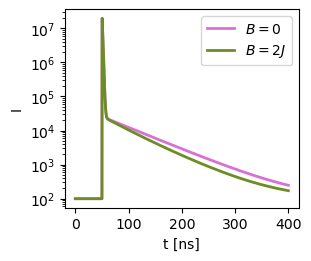

In [53]:
labels = [r"$B = 0$", r"$B = 2J$"]
colors = ["orchid", "olivedrab"]


fig, ax = plt.subplots(1, 1, figsize = (3,2.5), layout = "constrained")
a = ax
for i in range(len(Bs)):
    a.plot(tax, luminescence[i,:]*emission_rate + 10e1, label = labels[i], lw = 2, color = colors[i])

    a.legend(loc = "upper right")
    a.set_xlabel(r"t [ns]")
    a.set_ylabel(r"I")
    a.set_yscale("log")


Clearly , the fluorescence decay differs on and off the 2J resonance. At the 2J resonance, enhanced population of the triplet states alters the fluorescence lifetime. 
Now we are all set up - feel free to explore the system further! How about adding another spin? Electron spin relaxation? Explicit rotational diffusion with a stochastic Liouville equation? Try it out with SimOS! 

In [54]:
fig.savefig("complexmfe.pdf")